In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt
import numpy as np
from jaxtyping import Array, Float, PRNGKeyArray
import optax
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from diffrax import diffeqsolve, Dopri5, ODETerm

from sklearn.datasets import make_moons, make_blobs

## Make data

In [2]:
n_samples = 10000
n_cluster = 8
radius = 8
std = 0.5
centers = np.array(
    [
        np.array(
            [
                jnp.cos(2 * jnp.pi * i / n_cluster) * radius,
                jnp.sin(2 * jnp.pi * i / n_cluster) * radius,
            ]
        )
        for i in range(n_cluster)
    ]
)
blobs = make_blobs(
    n_samples=n_samples, n_features=2, centers=centers, cluster_std=std, random_state=42
)

moon = make_moons(n_samples=n_samples, noise=0.1, random_state=43)

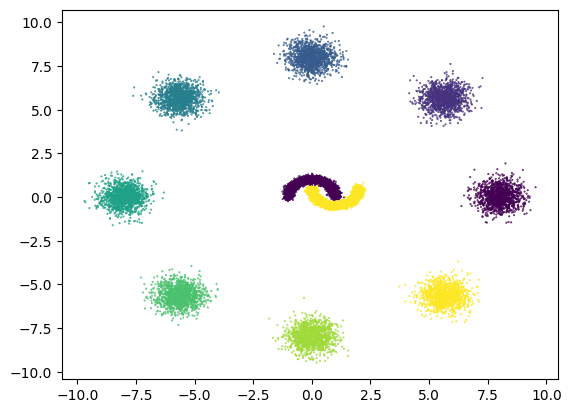

In [3]:
plt.scatter(blobs[0][:, 0], blobs[0][:, 1], c=blobs[1], s=0.2)
plt.scatter(moon[0][:, 0], moon[0][:, 1], c=moon[1], s=0.2)

## Choose pt and ut

In [4]:
def sample_conditional_pt(
    key: PRNGKeyArray,
    x0: Float[Array, "n_dim"],
    x1: Float[Array, "n_dim"],
    t: float,
    sigma: float,
):
    mu_t = t * x1 + (1 - t) * x0
    epsilon = jax.random.normal(key, mu_t.shape) * sigma
    return mu_t + epsilon

def compute_conditional_vector_field(x0: Float[Array, "n_dim"], x1: Float[Array, "n_dim"]):
    return (x1 - x0)

batch_sample_conditional_pt = jax.jit(jax.vmap(sample_conditional_pt, in_axes=(0, 0, 0, 0, None)))
batch_compute_conditional_vector_field = jax.jit(jax.vmap(compute_conditional_vector_field, in_axes=(0, 0)))

# Define model and training

In [5]:
key = jax.random.PRNGKey(9527)
sigma = 0.1
batch_size = 1000
learning_rate = 1e-3
n_dim = 2
width = 128
depth = 4

key, subkey = jax.random.split(key)
model = eqx.nn.MLP(n_dim+1, n_dim, key=subkey,width_size=width, depth=depth, activation=jax.nn.selu)
optimizer = optax.adam(learning_rate)
states = optimizer.init(eqx.filter(model, eqx.is_array))

dataset = TensorDataset(torch.tensor(blobs[0], dtype=torch.float32), torch.tensor(moon[0], dtype=torch.float32))
train_dataset, val_dataset = random_split(dataset, [int(0.8*len(dataset)), len(dataset) - int(0.8*len(dataset))])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [20]:
n_epoch = 100
@eqx.filter_jit
def loss(model, xt_with_t, ut):
    vt = jax.vmap(model)(xt_with_t)
    return jnp.mean(jnp.square(vt - ut))

for epoch in range(n_epoch):
    for (x0, x1) in train_loader:
        x0 = jnp.array(x0)
        x1 = jnp.array(x1)

        key, subkey = jax.random.split(key)
        t = jax.random.uniform(subkey, (batch_size, ))
        key, subkey = jax.random.split(key)
        subkey = jax.random.split(subkey, batch_size)
        xt = batch_sample_conditional_pt(subkey, x0, x1, t, sigma)
        ut = batch_compute_conditional_vector_field(x0, x1)

        loss_values, grads = eqx.filter_value_and_grad(loss)(model, jnp.concatenate([xt, t[:, None]], axis=-1), ut)
        updates, states = optimizer.update(grads, states)
        model = eqx.apply_updates(model, updates)
    
    print(f"Epoch {epoch}, Loss: {loss_values}")


Epoch 0, Loss: 5.621655464172363
Epoch 1, Loss: 5.649292469024658
Epoch 2, Loss: 5.601227283477783
Epoch 3, Loss: 6.285141944885254
Epoch 4, Loss: 5.269460201263428
Epoch 5, Loss: 6.028679370880127
Epoch 6, Loss: 5.135796546936035
Epoch 7, Loss: 6.488850116729736
Epoch 8, Loss: 5.534276485443115
Epoch 9, Loss: 6.711883544921875
Epoch 10, Loss: 5.987743377685547
Epoch 11, Loss: 6.524589538574219
Epoch 12, Loss: 5.883539199829102
Epoch 13, Loss: 5.5293145179748535
Epoch 14, Loss: 5.656816482543945
Epoch 15, Loss: 5.644394874572754
Epoch 16, Loss: 6.05375337600708
Epoch 17, Loss: 5.300175666809082
Epoch 18, Loss: 5.841184139251709
Epoch 19, Loss: 5.802256107330322
Epoch 20, Loss: 5.887091159820557
Epoch 21, Loss: 5.586176872253418
Epoch 22, Loss: 5.167952537536621
Epoch 23, Loss: 5.120744228363037
Epoch 24, Loss: 5.7087507247924805
Epoch 25, Loss: 5.8507795333862305
Epoch 26, Loss: 5.525829315185547
Epoch 27, Loss: 5.5274786949157715
Epoch 28, Loss: 5.026173114776611
Epoch 29, Loss: 5.504

In [21]:

test_samples = make_blobs(n_samples=1000, n_features=2, centers=centers, cluster_std=std, random_state=24)
test_samples = jnp.array(test_samples[0])

term = ODETerm(lambda t, x, args: model(jnp.concatenate([x, jnp.array([t])], axis=-1)))
solver = Dopri5()

@eqx.filter_jit
@eqx.filter_vmap
def transport(x):
    return diffeqsolve(term, solver, t0=0, t1=1, y0=x, dt0=1e-3)

In [22]:
transported_samples = transport(test_samples)

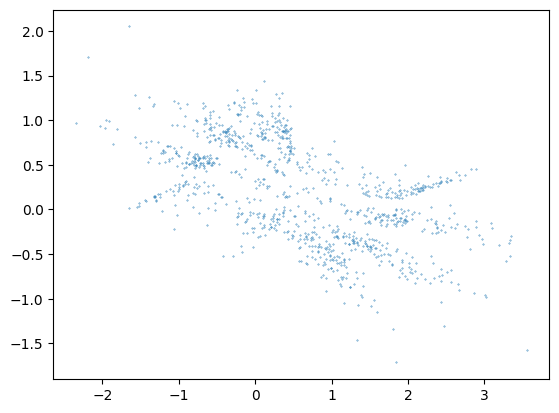

In [23]:
plt.scatter(transported_samples.ys[:,0,0],transported_samples.ys[:,0,1],s=0.1)